# Predicting NDX from the closing prices of SPX and DJI

In [1]:
from google.colab import files
uploaded = files.upload()


Saving spx_daily_85.csv to spx_daily_85.csv
Saving ndx_daily_85.csv to ndx_daily_85.csv
Saving dji_daily_85.csv to dji_daily_85.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from keras.regularizers import l2
from sklearn.metrics import mean_absolute_error, mean_squared_error

# All features

In [3]:
# Load datasets
spx_data = pd.read_csv('spx_daily_85.csv')
ndx_data = pd.read_csv('ndx_daily_85.csv')
dow_data = pd.read_csv('dji_daily_85.csv')

In [4]:
# Convert the Date column to datetime
for df in [spx_data, ndx_data]:
    df['Date'] = pd.to_datetime(df['Date'])

# Merge the datasets on Date, including all relevant features (Open, High, Low, Close, Volume)
merged_data = spx_data[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']].rename(columns={
    'Open':  'SPX_Open', 'High': 'SPX_High', 'Low': 'SPX_Low', 'Close': 'SPX_Close', 'Volume': 'SPX_Volume'})

merged_data = merged_data.merge(ndx_data[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']].rename(columns={
        'Open': 'NDX_Open', 'High': 'NDX_High', 'Low': 'NDX_Low', 'Close': 'NDX_Close', 'Volume': 'NDX_Volume'}), on='Date')


# Sort the data by the 'Date' column in ascending order
merged_data = merged_data.sort_values(by='Date', ascending=True)

# Drop any rows with missing values
merged_data.dropna(inplace=True)

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(merged_data.drop(columns=['Date']))

In [5]:
merged_data.head()

,Date,SPX_Open,SPX_High,SPX_Low,SPX_Close,SPX_Volume,NDX_Open,NDX_High,NDX_Low,NDX_Close,NDX_Volume
0,1985-10-01,182.06,185.08,182.02,185.07,72333333.0,110.62,112.16,110.57,112.14,26406897.0
1,1985-10-02,185.07,185.94,184.06,184.06,81833333.0,112.14,112.54,110.78,110.82,28386207.0
2,1985-10-03,184.06,185.17,183.59,184.36,70833333.0,110.84,111.18,110.12,110.87,25396552.0
3,1985-10-04,184.36,184.36,182.65,183.22,56222222.0,110.87,110.87,109.86,110.07,25500000.0
4,1985-10-07,183.22,183.22,181.30,181.87,53083333.0,110.07,110.14,108.18,108.20,22179310.0


In [6]:
# Prepare the data for time series analysis
def create_sequences(data, sequence_length):
    xs = []
    ys = []
    for i in range(len(data) - sequence_length):
        x = data[i:i+sequence_length, 0:6]  # Use all features except NDX variables
        y = data[i+sequence_length, -2]  # Target is NDX_Close
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

sequence_length = 7  # Number of days to look back
X, y = create_sequences(scaled_data, sequence_length)

# Split the data into training and testing sets
split_ratio = 0.8
split_index = int(split_ratio * len(X))

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]


In [7]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=64, kernel_regularizer=l2(0.01), return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=32, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(units=1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [8]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_absolute_error')

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Make predictions
predictions = model.predict(X_test)

mae = mean_absolute_error(y_test, predictions)
print("Mean Absolute Error (MAE):", mae)

mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error (MSE):", mse)

rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

Epoch 1/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.9229 - val_loss: 0.7443
Epoch 2/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.6597 - val_loss: 0.5393
Epoch 3/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.4696 - val_loss: 0.3884
Epoch 4/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3301 - val_loss: 0.2793
Epoch 5/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2298 - val_loss: 0.1985
Epoch 6/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1576 - val_loss: 0.1409
Epoch 7/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1069 - val_loss: 0.1048
Epoch 8/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0716 - val_loss: 0.0739
Epoch 9/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0482 - val_loss: 0.0574
Epoch 10/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0329 - val_loss: 0.0427
Epoch 11/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0229 - val_loss: 0.0310
Epoch 12/100
196/196 ━━━━━━━━━━━━━━━━━━━━

In [9]:
# Create a placeholder for inverse transformation
predicted_ndx_full = np.zeros((predictions.shape[0], scaled_data.shape[1]))
actual_ndx_full = np.zeros((y_test.shape[0], scaled_data.shape[1]))

# Fill the placeholder with predicted values (only for the NDX_Close column)
predicted_ndx_full[:, -2] = predictions[:, 0]
actual_ndx_full[:, -2] = y_test

# Inverse transform to get the original scale
predicted_ndx = scaler.inverse_transform(predicted_ndx_full)[:, -2]
actual_ndx = scaler.inverse_transform(actual_ndx_full)[:, -2]


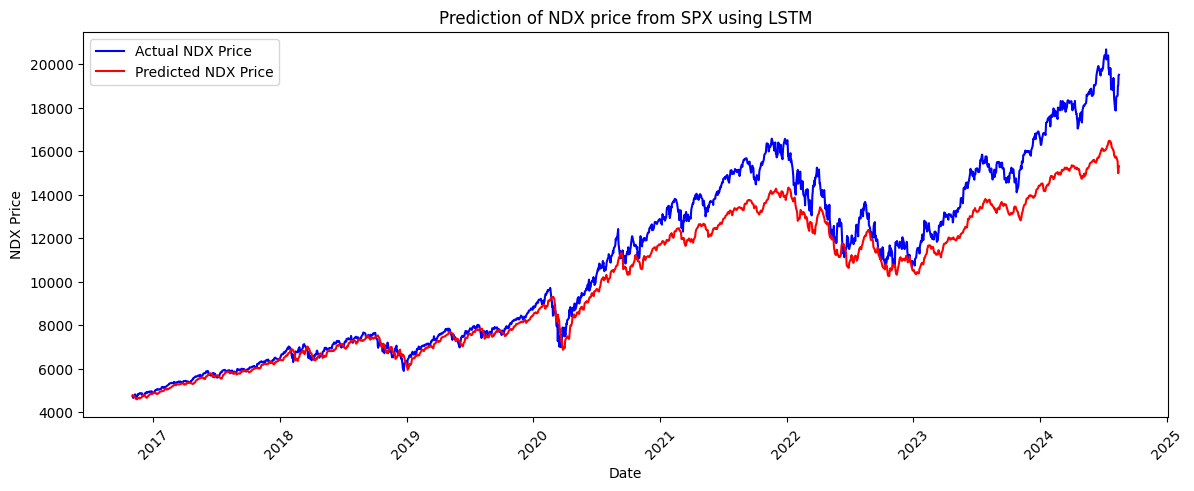

In [10]:
# Create a date range for the test set
test_dates = merged_data['Date'].iloc[split_index + sequence_length:].values

# Plot the results with dates on the x-axis
plt.figure(figsize=(14, 5))
plt.plot(test_dates, actual_ndx, color='blue', label='Actual NDX Price')
plt.plot(test_dates, predicted_ndx, color='red', label='Predicted NDX Price')
plt.title('Prediction of NDX price from SPX using LSTM')
plt.xlabel('Date')
plt.ylabel('NDX Price')
plt.xticks(rotation=45) 
plt.legend()
plt.show()


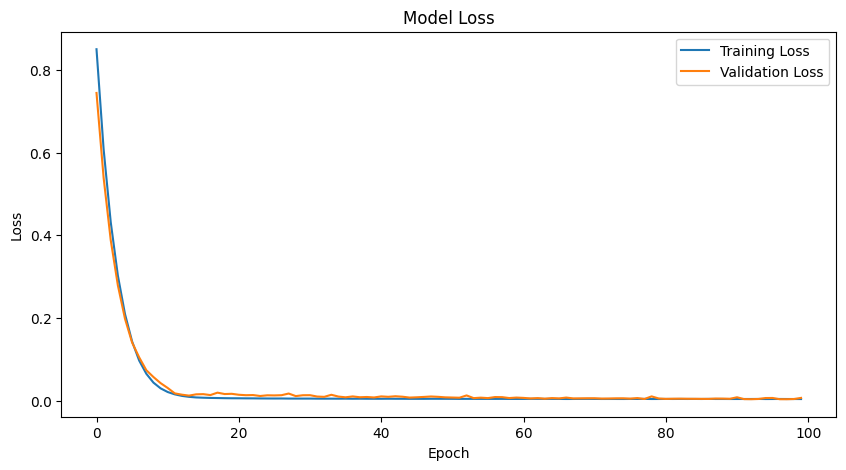

In [11]:
# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# Prediction of SPX stock prices

# All features

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

In [13]:
# Load datasets
spx_data = pd.read_csv('spx_daily_85.csv')
ndx_data = pd.read_csv('ndx_daily_85.csv')
dow_data = pd.read_csv('dji_daily_85.csv')

In [14]:
# Convert the Date column to datetime
for df in [ndx_data, spx_data]:
    df['Date'] = pd.to_datetime(df['Date'])

# Merge the datasets on Date, including all relevant features (Open, High, Low, Close, Volume)
merged_data = ndx_data[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']].rename(columns={
    'Open': 'NDX_Open', 'High': 'NDX_High', 'Low': 'NDX_Low', 'Close': 'NDX_Close', 'Volume': 'NDX_Volume'})
merged_data = merged_data.merge(
    spx_data[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']].rename(columns={
        'Open': 'SPX_Open', 'High': 'SPX_High', 'Low': 'SPX_Low', 'Close': 'SPX_Close', 'Volume': 'SPX_Volume'}), on='Date')


# Sort the data by the 'Date' column in ascending order
merged_data = merged_data.sort_values(by='Date', ascending=True)

# Drop any rows with missing values
merged_data.dropna(inplace=True)

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(merged_data.drop(columns=['Date']))


In [15]:
merged_data.tail()

,Date,NDX_Open,NDX_High,NDX_Low,NDX_Close,NDX_Volume,SPX_Open,SPX_High,SPX_Low,SPX_Close,SPX_Volume
9793,2024-08-12,18548.23,18665.75,18433.61,18542.03,9.853609e+08,5351.88,5371.20,5324.37,5344.39,2.285608e+09
9794,2024-08-13,18724.84,19013.02,18723.75,19006.43,1.199671e+09,5376.98,5436.50,5376.98,5434.43,2.602424e+09
9795,2024-08-14,19043.76,19103.00,18837.10,19022.68,1.090248e+09,5442.36,5463.22,5415.91,5455.21,2.352133e+09
9796,2024-08-15,19251.86,19502.92,19239.94,19490.15,1.231034e+09,5501.13,5546.23,5501.13,5543.22,2.676736e+09
9797,2024-08-16,19393.73,19561.24,19376.72,19508.52,1.036048e+09,5530.50,5561.98,5525.17,5554.25,2.288641e+09


In [16]:
# Prepare the data for time series analysis
def create_sequences(data, sequence_length):
    xs = []
    ys = []
    for i in range(len(data) - sequence_length):
        x = data[i:i+sequence_length, 0:6]  # Use all features except SPX variables
        y = data[i+sequence_length, -2]  # Target is SPX_Close
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

sequence_length = 7  
X, y = create_sequences(scaled_data, sequence_length)

# Split the data into training and testing sets
split_ratio = 0.8
split_index = int(split_ratio * len(X))

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

In [17]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=64, kernel_regularizer=l2(0.01), return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=32, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(units=1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [18]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_absolute_error')

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Make predictions
predictions = model.predict(X_test)


mae = mean_absolute_error(y_test, predictions)
print("Mean Absolute Error (MAE):", mae)

mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error (MSE):", mse)

rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

Epoch 1/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.9724 - val_loss: 0.7159
Epoch 2/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.6706 - val_loss: 0.5226
Epoch 3/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.4779 - val_loss: 0.3678
Epoch 4/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3380 - val_loss: 0.2570
Epoch 5/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2369 - val_loss: 0.1744
Epoch 6/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1651 - val_loss: 0.1192
Epoch 7/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1141 - val_loss: 0.0811
Epoch 8/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0790 - val_loss: 0.0575
Epoch 9/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0546 - val_loss: 0.0374
Epoch 10/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0388 - val_loss: 0.0275
Epoch 11/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0284 - val_loss: 0.0239
Epoch 12/100
196/196 ━━━━━━━━━━━━━━━━━━━━

In [19]:
# Create a placeholder for inverse transformation
predicted_spx_full = np.zeros((predictions.shape[0], scaled_data.shape[1]))
actual_spx_full = np.zeros((y_test.shape[0], scaled_data.shape[1]))

# Fill the placeholder with predicted values (only for the SPX_Close column)
predicted_spx_full[:, -2] = predictions[:, 0]
actual_spx_full[:, -2] = y_test

# Inverse transform to get the original scale
predicted_spx = scaler.inverse_transform(predicted_spx_full)[:, -2]
actual_spx = scaler.inverse_transform(actual_spx_full)[:, -2]

# Create a date range for the test set
test_dates = merged_data['Date'].iloc[split_index + sequence_length:].values

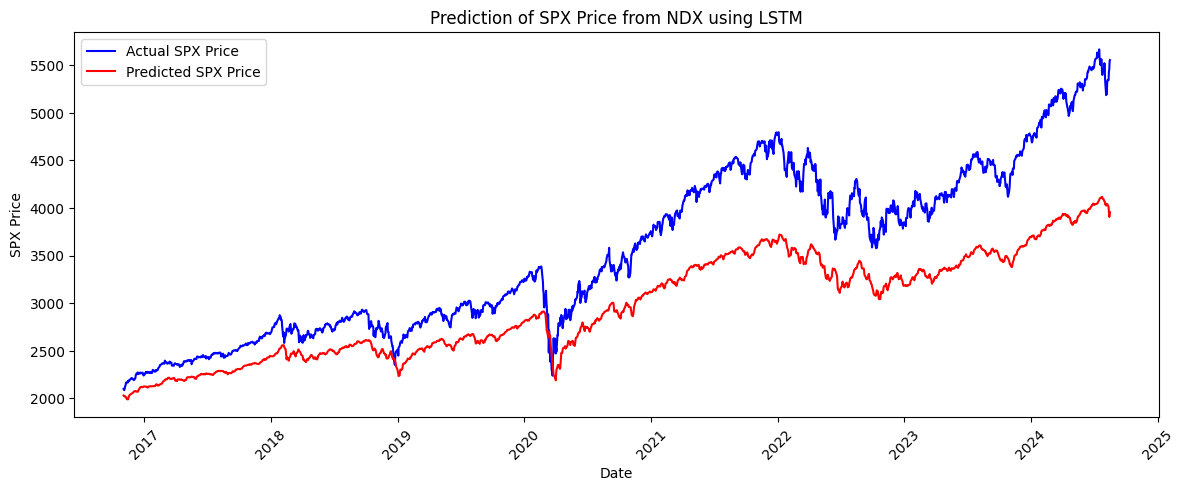

In [20]:
# Plot the results with dates on the x-axis
plt.figure(figsize=(14, 5))
plt.plot(test_dates, actual_spx, color='blue', label='Actual SPX Price')
plt.plot(test_dates, predicted_spx, color='red', label='Predicted SPX Price')
plt.title('Prediction of SPX Price from NDX using LSTM')
plt.xlabel('Date')
plt.ylabel('SPX Price')
plt.xticks(rotation=45)  
plt.legend()
plt.show()

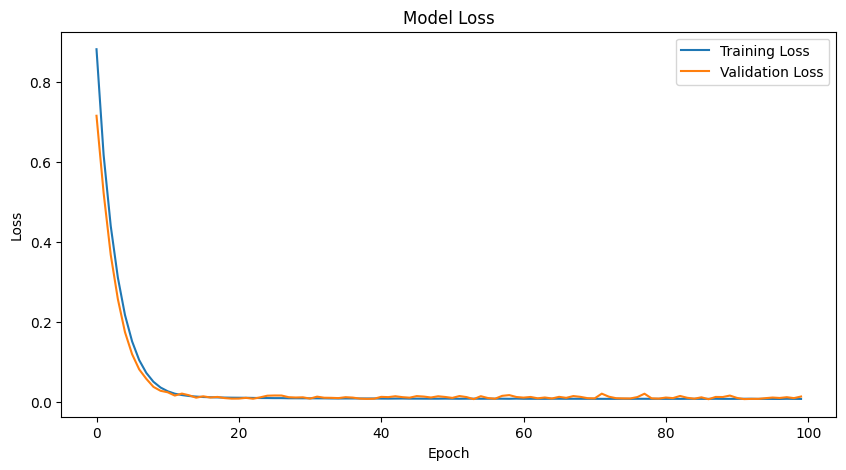

In [21]:
# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# SPX Prediction using DJI and NDX values as features

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [23]:
# Loading the datasets
spx_data = pd.read_csv('spx_daily_85.csv')
ndx_data = pd.read_csv('ndx_daily_85.csv')
dow_data = pd.read_csv('dji_daily_85.csv')

In [24]:
# Convert the Date column to datetime
for df in [ndx_data, spx_data, dow_data]:
    df['Date'] = pd.to_datetime(df['Date'])

# Merge the datasets on Date, including all relevant features (Open, High, Low, Close, Volume)
merged_data = dow_data[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']].rename(columns={
        'Open': 'DOW_Open', 'High': 'DOW_High', 'Low': 'DOW_Low', 'Close': 'DOW_Close', 'Volume': 'DOW_Volume'})
merged_data = merged_data.merge(
    ndx_data[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']].rename(columns={
        'Open': 'NDX_Open', 'High': 'NDX_High', 'Low': 'NDX_Low', 'Close': 'NDX_Close', 'Volume': 'NDX_Volume'}), on='Date')
merged_data = merged_data.merge(
    spx_data[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']].rename(columns={
        'Open': 'SPX_Open', 'High': 'SPX_High', 'Low': 'SPX_Low', 'Close': 'SPX_Close', 'Volume': 'SPX_Volume'}), on='Date')

# Sort the data by the 'Date' column in ascending order
merged_data = merged_data.sort_values(by='Date', ascending=True)

# Drop any rows with missing values
merged_data.dropna(inplace=True)

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(merged_data.drop(columns=['Date']))


In [25]:
merged_data.head()

,Date,DOW_Open,DOW_High,DOW_Low,DOW_Close,DOW_Volume,NDX_Open,NDX_High,NDX_Low,NDX_Close,NDX_Volume,SPX_Open,SPX_High,SPX_Low,SPX_Close,SPX_Volume
0,1985-10-01,1328.6,1344.0,1323.5,1341.0,15600373.0,110.62,112.16,110.57,112.14,26406897.0,182.06,185.08,182.02,185.07,72333333.0
1,1985-10-02,1341.0,1351.6,1328.0,1333.7,12576478.0,112.14,112.54,110.78,110.82,28386207.0,185.07,185.94,184.06,184.06,81833333.0
2,1985-10-03,1333.7,1345.4,1323.8,1333.1,10694575.0,110.84,111.18,110.12,110.87,25396552.0,184.06,185.17,183.59,184.36,70833333.0
3,1985-10-04,1333.1,1335.0,1321.1,1328.7,8829276.0,110.87,110.87,109.86,110.07,25500000.0,184.36,184.36,182.65,183.22,56222222.0
4,1985-10-07,1328.7,1335.9,1315.2,1324.4,9299219.0,110.07,110.14,108.18,108.20,22179310.0,183.22,183.22,181.30,181.87,53083333.0


In [26]:
# Prepare the data for time series analysis
def create_sequences(data, sequence_length):
    xs = []
    ys = []
    for i in range(len(data) - sequence_length):
        x = data[i:i+sequence_length, :-5]  # Use all features except SPX variables
        y = data[i+sequence_length, -2]  # Target is SPX_Close
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

sequence_length = 7  # Number of days to look back
X, y = create_sequences(scaled_data, sequence_length)

# Split the data into training and testing sets
split_ratio = 0.8
split_index = int(split_ratio * len(X))

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

In [27]:
# LSTM model
model = Sequential()
model.add(LSTM(units=64, kernel_regularizer=l2(0.01), return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=32, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(units=1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [28]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_absolute_error')

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Make predictions
predictions = model.predict(X_test)

mae = mean_absolute_error(y_test, predictions)
print("Mean Absolute Error (MAE):", mae)

mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error (MSE):", mse)

rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

Epoch 1/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 1.0189 - val_loss: 0.7708
Epoch 2/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.7130 - val_loss: 0.5512
Epoch 3/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.5105 - val_loss: 0.3954
Epoch 4/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3628 - val_loss: 0.2835
Epoch 5/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2557 - val_loss: 0.2076
Epoch 6/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1786 - val_loss: 0.1509
Epoch 7/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1244 - val_loss: 0.1074
Epoch 8/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0864 - val_loss: 0.0831
Epoch 9/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0606 - val_loss: 0.0585
Epoch 10/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0435 - val_loss: 0.0488
Epoch 11/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0316 - val_loss: 0.0454
Epoch 12/100
196/196 ━━━━━━━━━━━━━━━━━━━━

In [29]:
# Create a placeholder for inverse transformation
predicted_spx_full = np.zeros((predictions.shape[0], scaled_data.shape[1]))
actual_spx_full = np.zeros((y_test.shape[0], scaled_data.shape[1]))

# Fill the placeholder with predicted values (only for the SPX_Close column)
predicted_spx_full[:, -2] = predictions[:, 0]
actual_spx_full[:, -2] = y_test

# Inverse transform to get the original scale
predicted_spx = scaler.inverse_transform(predicted_spx_full)[:, -2]
actual_spx = scaler.inverse_transform(actual_spx_full)[:, -2]

# Create a date range for the test set
test_dates = merged_data['Date'].iloc[split_index + sequence_length:].values


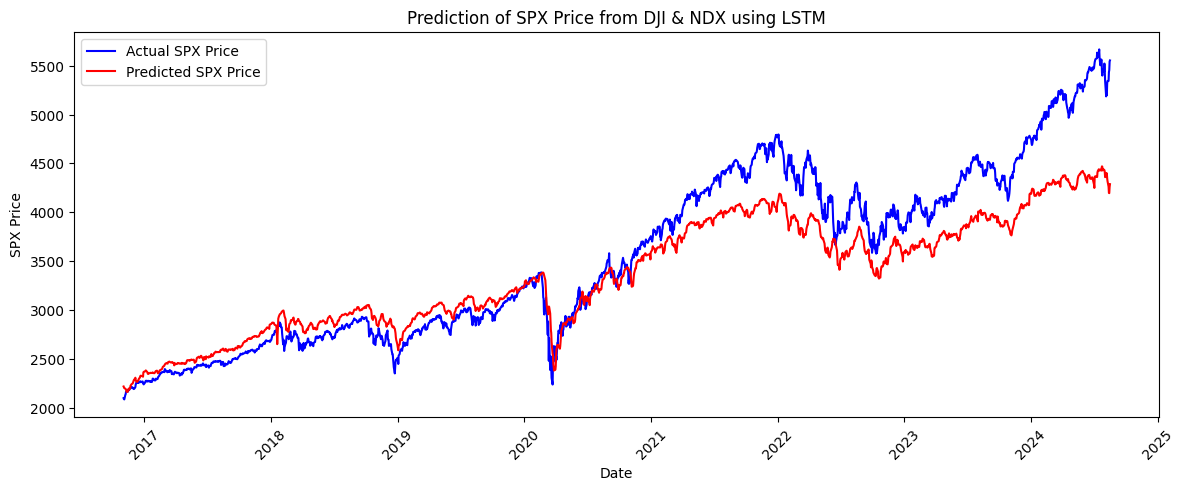

In [30]:
# Plot the results with dates on the x-axis
plt.figure(figsize=(14, 5))
plt.plot(test_dates, actual_spx, color='blue', label='Actual SPX Price')
plt.plot(test_dates, predicted_spx, color='red', label='Predicted SPX Price')
plt.title('Prediction of SPX Price from DJI & NDX using LSTM')
plt.xlabel('Date')
plt.ylabel('SPX Price')
plt.xticks(rotation=45)  
plt.legend()
plt.show()

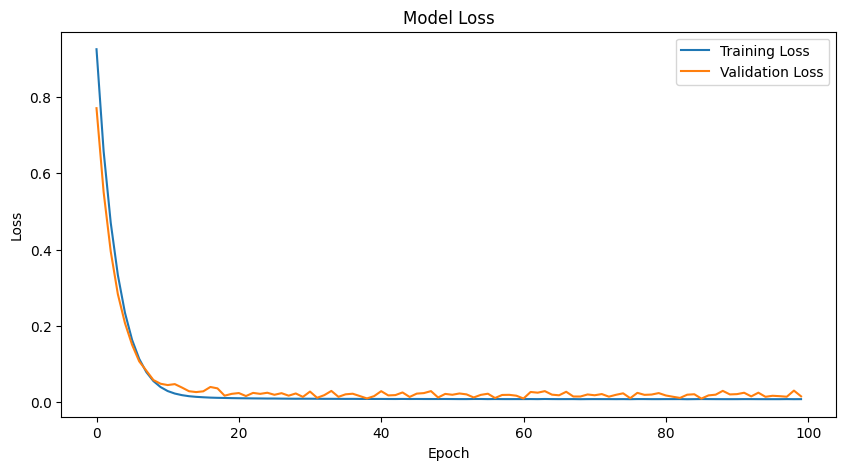

In [31]:
# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

## **NDX prediction from DJI & SPX**

In [32]:
# Convert the Date column to datetime
for df in [ndx_data, spx_data, dow_data]:
    df['Date'] = pd.to_datetime(df['Date'])

# Merge the datasets on Date, including all relevant features (Open, High, Low, Close, Volume)
merged_data = dow_data[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']].rename(columns={
        'Open': 'DOW_Open', 'High': 'DOW_High', 'Low': 'DOW_Low', 'Close': 'DOW_Close', 'Volume': 'DOW_Volume'})
merged_data = merged_data.merge(
    spx_data[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']].rename(columns={
        'Open': 'SPX_Open', 'High': 'SPX_High', 'Low': 'SPX_Low', 'Close': 'SPX_Close', 'Volume': 'SPX_Volume'}), on='Date')
merged_data = merged_data.merge(
    ndx_data[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']].rename(columns={
        'Open': 'NDX_Open', 'High': 'NDX_High', 'Low': 'NDX_Low', 'Close': 'NDX_Close', 'Volume': 'NDX_Volume'}), on='Date')

# Sort the data by the 'Date' column in ascending order
merged_data = merged_data.sort_values(by='Date', ascending=True)

# Drop any rows with missing values
merged_data.dropna(inplace=True)

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(merged_data.drop(columns=['Date']))

In [33]:
# Prepare the data for time series analysis
def create_sequences(data, sequence_length):
    xs = []
    ys = []
    for i in range(len(data) - sequence_length):
        x = data[i:i+sequence_length, :-5]  # Use all features except NDX variables
        y = data[i+sequence_length, -2]  # Target is NDX_Close
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

sequence_length = 7  # Number of days to look back
X, y = create_sequences(scaled_data, sequence_length)

# Split the data into training and testing sets
split_ratio = 0.8
split_index = int(split_ratio * len(X))

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

In [34]:
# LSTM model
model = Sequential()
model.add(LSTM(units=64, kernel_regularizer=l2(0.01), return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=32, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(units=1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [35]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_absolute_error')

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Make predictions
predictions = model.predict(X_test)

mae = mean_absolute_error(y_test, predictions)
print("Mean Absolute Error (MAE):", mae)

mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error (MSE):", mse)

rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

Epoch 1/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.9910 - val_loss: 0.8028
Epoch 2/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.7071 - val_loss: 0.5807
Epoch 3/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.5047 - val_loss: 0.4230
Epoch 4/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3562 - val_loss: 0.3047
Epoch 5/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2482 - val_loss: 0.2195
Epoch 6/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1717 - val_loss: 0.1671
Epoch 7/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1171 - val_loss: 0.1237
Epoch 8/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0795 - val_loss: 0.0935
Epoch 9/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0540 - val_loss: 0.0749
Epoch 10/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0377 - val_loss: 0.0632
Epoch 11/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0272 - val_loss: 0.0559
Epoch 12/100
196/196 ━━━━━━━━━━━━━━━━━━━━

In [36]:
## Create a placeholder for inverse transformation
# Since the scaler was fitted on all columns, we need to recreate this shape
predicted_ndx_full = np.zeros((predictions.shape[0], scaled_data.shape[1]))
actual_ndx_full = np.zeros((y_test.shape[0], scaled_data.shape[1]))

# Fill the placeholder with predicted values (only for the NDX_Close column)
predicted_ndx_full[:, -2] = predictions[:, 0]
actual_ndx_full[:, -2] = y_test

# Inverse transform to get the original scale
predicted_ndx = scaler.inverse_transform(predicted_ndx_full)[:, -2]
actual_ndx = scaler.inverse_transform(actual_ndx_full)[:, -2]

# Create a date range for the test set
test_dates = merged_data['Date'].iloc[split_index + sequence_length:].values

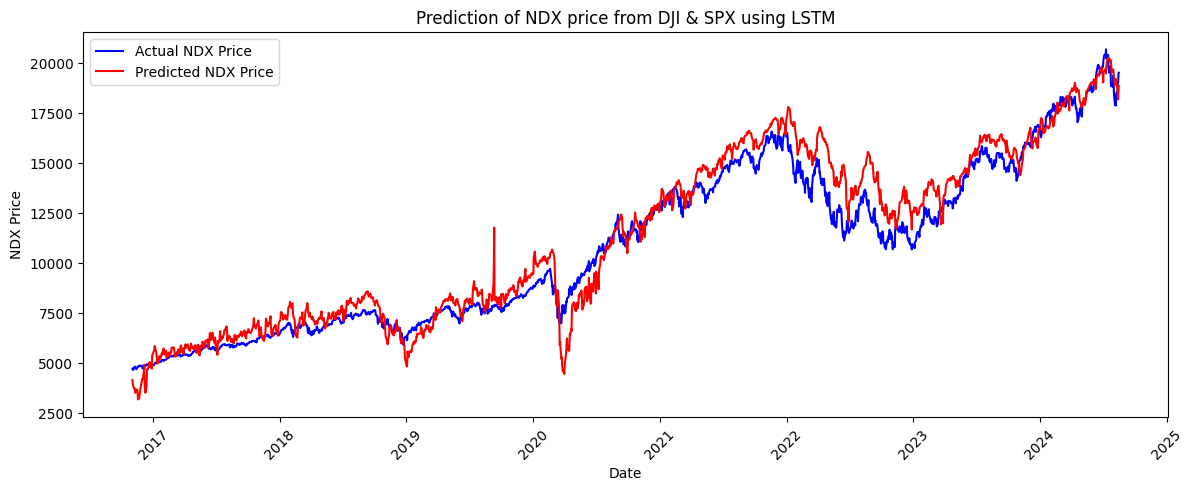

In [37]:
# Plot the results with dates on the x-axis
plt.figure(figsize=(14, 5))
plt.plot(test_dates, actual_ndx, color='blue', label='Actual NDX Price')
plt.plot(test_dates, predicted_ndx, color='red', label='Predicted NDX Price')
plt.title('Prediction of NDX price from DJI & SPX using LSTM')
plt.xlabel('Date')
plt.ylabel('NDX Price')
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.legend()
plt.show()

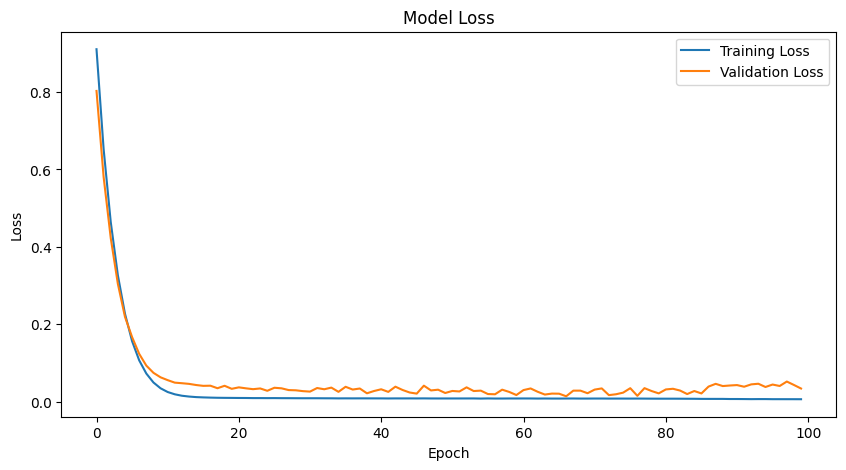

In [38]:
# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()